In [1]:
import split_op as split
import numpy as np
from scipy.special import roots_legendre, lpmv
from tqdm import tqdm

from potential import load_potential
import os

data_path = "data/"
if not os.path.exists(data_path):
    os.makedirs(data_path)

CM_INV = 4.55633e-6
KELVIN = 3.1668105e-6
U = 1822.88839

def centrifugal(r_points, j_tot: int, omega: int, mass_u: float):
    return (j_tot * (j_tot + 1) - 2 * omega * omega) / (2 * mass_u * U * np.power(r_points, 2))

class Potential:
    def __init__(self, r_o, r_c, r_s, d6_o, d6_c, d6_s, re_o, re_c, re_s, alpha):
        self.r_o = r_o
        self.r_c = r_c
        self.r_s = r_s
        self.d6_o = d6_o
        self.d6_c = d6_c
        self.d6_s = d6_s
        self.re_o = re_o
        self.re_c = re_c
        self.re_s = re_s
        self.alpha = alpha
    
    @staticmethod
    def default():
        return Potential(3.1787, 0.9908, -1.957, 
                         1.09853700e-5, 2.35435928e-04, 7.63334226e-05, 
                         8.9643377e+00, 9.73677283e+00, 1.02445905e+01, 
                         1.23674328e+02)

    def value(self, r, theta):
        r_o = np.sqrt(r ** 2 + self.r_o ** 2 - 2 * r * self.r_o * np.cos(theta))
        r_c = np.sqrt(r ** 2 + self.r_c ** 2 - 2 * r * self.r_c * np.cos(theta))
        r_s = np.sqrt(r ** 2 + self.r_s ** 2 - 2 * r * self.r_s * np.cos(theta))

        pot_o = self.d6_o * (self.re_o / r_o) ** 6 * ((self.re_o / r_o) ** 6 - 2)
        pot_c = self.d6_c * (self.re_c / r_c) ** 6 * ((self.re_c / r_c) ** 6 - 2)
        pot_s = self.d6_s * (self.re_s / r_s) ** 6 * ((self.re_s / r_s) ** 6 - 2)

        pot_dip = -self.alpha * np.cos(theta) ** 2 / (r ** 6)

        return pot_o + pot_c + pot_s + pot_dip

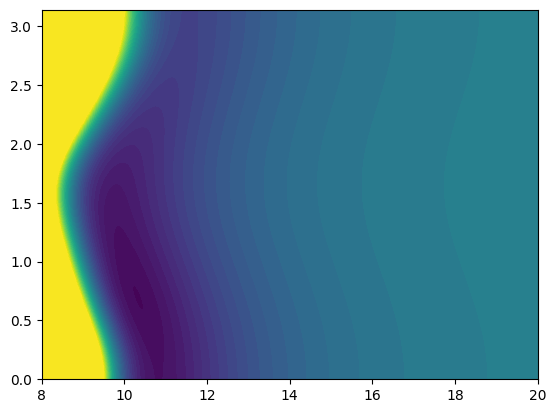

In [2]:
import matplotlib.pyplot as plt

r = np.linspace(8, 20, 300)
theta = np.linspace(0, np.pi, 100)

theta_mesh, r_mesh = np.meshgrid(theta, r, indexing="ij")
potential_array = Potential.default().value(r_mesh, theta_mesh) / CM_INV

potential_array = np.clip(potential_array, -1000, 100)

fig, ax = plt.subplots()
ax.contourf(r, theta, potential_array, levels=50)

In [3]:
from typing import Callable

def prepare(j_init: int, 
    omega_init: int, 
    j_tot: int, 
    time_step: float = 200, 
    steps_no: float = 300, 
    r_start: float = 50 / 1024, 
    r_end: float = 50, 
    r_no: int = 1024, 
    polar_no: int = 160, 
    mass_u: float = 15.1052848671,
    energy_kelvin: float = 3700, 
    rot_const = 9.243165268327e-7,
    wave_r0: float = 30,
    wave_r_sigma: float = 0.6,
    animation: bool = False,
    frames: int = 60,
    wave_prefix: str = "force_field",
    potential: Potential = Potential.default(),
    potential_path = "potentials/",
    transform_xpi: Callable[[float, float], float] = None,
    transform_bsigma: Callable[[float, float], float] = None,
    transform_api: Callable[[float, float], float] = None,
) -> split.Propagation:
    """
    Prepares the split operator propagation of the Ne OCS problem.

    :j_init: initial angular momentum of the OCS molecule
    :omega_init: initial body fixed projection of the OCS angular momentum equal to projection of the total angular momentum
    :j_tot: total angular momentum of the system
    :time_step: time step in the Hartree units of the propagation step
    :steps_no: number of steps in the propagation
    :r_start: starting value of the radial grid
    :r_end: ending value of the radial grid
    :r_no: number of points of the radial grid
    :polar_no: number of points of the angular grid
    :mass_u: reduced mass of the Ne OCS in u units
    :energy_kelvin: energy of the collision in Kelvin units
    :rot_const: rotational constant of the OCS molecule in Hartree units
    :wave_r0: initial radial position of the wave funciton
    :wave_r_sigma: initial radial width of the wave funciton
    :animation: whether to save animations of the wave function
    :frames: number of frames of the animation
    :wave_prefix: prefix of the wave animation filename to be saved
    :potential: Potential force field form
    :potential_path: path to the potential data
    :transform_xpi: custom transformation to the XPi gamma potential
    :transform_bsigma: custom transformation to the BSigma gamma potential
    :transform_api: custom transformation to the APi gamma potential
    """

    assert j_tot >= omega_init
    assert j_init >= omega_init

    ############################ grids, wave function creation ################################
    
    time_grid = split.TimeGrid(time_step, steps_no)
    r_grid = split.Grid.linear_continuos("r", r_start, r_end, r_no, 0)
    
    polar_points, weights = roots_legendre(polar_no)
    polar_points = np.flip(np.arccos(polar_points))
    weights = np.flip(weights)
    
    polar_grid = split.Grid.custom("theta", polar_points, weights, 1)

    r_points = np.array(r_grid.points())
    momentum = np.sqrt(2 * mass_u * U * energy_kelvin * KELVIN)

    wave_r_init = np.array([split.gaussian_distribution(r_points[i], wave_r0, wave_r_sigma, momentum) for i in range(r_no)])
    wave_polar_init = lpmv(omega_init, j_init, np.cos(polar_points))

    wave_init = np.outer(wave_r_init, wave_polar_init)
    wave_function = split.WaveFunction(wave_init.flatten(), [r_grid, polar_grid])

    ############################ operation creation ################################

    r_mesh, polar_mesh = np.meshgrid(r_points, polar_points, indexing="ij")

    potential_array = potential.value(r_mesh, polar_mesh)

    centrifugal_potential = centrifugal(r_points, j_tot, omega_init, mass_u)
    centrifugal_potential = np.broadcast_to(np.expand_dims(centrifugal_potential, 1), (r_no, polar_no))

    bsigma_gamma = load_potential(potential_path, "BSigma_gamma.dat", r_grid, polar_grid, 5, 5, True)
    if transform_bsigma is not None:
        bsigma_gamma = np.multiply(bsigma_gamma, transform_bsigma(r_mesh, polar_mesh))

    api_gamma = load_potential(potential_path, "APi_gamma.dat", r_grid, polar_grid, 5, 5, True)
    if transform_api is not None:
        api_gamma = np.multiply(api_gamma, transform_api(r_mesh, polar_mesh))

    potential_array = potential_array + centrifugal_potential + complex(0, -0.5) * (bsigma_gamma + api_gamma)
    potential_with_bsigma_prop = split.complex_n_dim_into_propagator(potential_array.shape, potential_array.flatten(), time_grid)

    loss_checker = split.LossChecker.new_with_saver("bsigma", frames, f"{wave_prefix}_bsigma", time_grid) if animation else split.LossChecker("bsigma")
    potential_with_bsigma_prop.set_loss_checked(loss_checker)

    xpi_gamma = load_potential(potential_path, "XPi_gamma.dat", r_grid, polar_grid, 5, 3, True)
    if transform_xpi is not None:
        xpi_gamma = np.multiply(xpi_gamma, transform_xpi(r_mesh, polar_mesh))

    xpi_gamma = complex(0, -0.5) * xpi_gamma
    xpi_gamma_prop = split.complex_n_dim_into_propagator(xpi_gamma.shape, xpi_gamma.flatten(), time_grid)
    
    loss_checker = split.LossChecker.new_with_saver("xpi", frames, f"{wave_prefix}_xpi", time_grid) if animation else split.LossChecker("xpi")
    xpi_gamma_prop.set_loss_checked(loss_checker)

    leak_control = split.LeakControl(split.LossChecker("leak control"))
    dumping_border = split.BorderDumping(5., 1., r_grid)

    angular_transformation = split.associated_legendre_transformation(polar_grid, omega_init)

    shape, angular_kinetic_op = split.rotational_hamiltonian(r_grid, polar_grid, mass_u, rot_const)
    angular_prop = split.n_dim_into_propagator(shape, angular_kinetic_op, time_grid)

    fft_transformation = split.FFTTransformation(r_grid, "r momentum")

    kinetic_op = split.kinetic_hamiltonian(r_grid, mass_u, energy_kelvin)
    kinetic_prop = split.one_dim_into_propagator(kinetic_op, r_grid, time_grid, step = "full")

    ################################ populating operation stack ####################################

    operation_stack = split.OperationStack()
    potential_with_bsigma_prop.add_operation(operation_stack)
    xpi_gamma_prop.add_operation(operation_stack)

    if animation:
        wave_saver = split.WaveFunctionSaver(data_path, f"{wave_prefix}_wave_animation", time_grid, r_grid, polar_grid, frames)
        wave_saver.add_operation(operation_stack)

        polar_saver = split.StateSaver(data_path, f"{wave_prefix}_polar_animation", time_grid, polar_grid, frames)
        polar_saver.add_operation(operation_stack)

    dumping_border.add_operation(operation_stack)
    leak_control.add_operation(operation_stack)

    angular_transformation.add_operation(operation_stack, True)

    if animation:
        angular_grid = angular_transformation.transformed_grid()
        wave_legendre_saver = split.StateSaver(data_path, f"{wave_prefix}_angular_animation", time_grid, angular_grid, frames)
        wave_legendre_saver.add_operation(operation_stack)

    angular_prop.add_operation(operation_stack)

    fft_transformation.add_operation(operation_stack, True)
    kinetic_prop.add_operation(operation_stack)

    ################################ propagation creation ####################################

    propagation = split.Propagation()
    propagation.set_wave_function(wave_function)
    propagation.set_time_grid(time_grid)
    propagation.set_operation_stack(operation_stack)

    return propagation

def default_value(name: str):
    import inspect

    return inspect.signature(prepare).parameters.get(name).default

class CumulativeLosses:
    def __init__(self, j_init: int, energy_kelvin: float = default_value("energy_kelvin")) -> None:
        self.bsigma_losses = []
        self.xpi_losses = []

        self.j_totals = [j_init + np.ceil(i * 5.5 * np.sqrt(energy_kelvin / 2000)) for i in range(50)]
    
    def extract_loss(self, propagation: split.Propagation) -> None:
        losses = propagation.get_losses()

        self.bsigma_losses.append(losses[0])
        self.xpi_losses.append(losses[1])

    def save_losses(self, filename: str) -> None:
        combined = np.vstack((self.j_totals, self.bsigma_losses, self.xpi_losses)).transpose()
        np.savetxt(f"{data_path}{filename}.dat", combined, delimiter=" ", header="j_total\tbsigma_loss\txpi_loss")

# Force Field calculation

In [4]:
print("j init: 0, omega init: 0, j_tot: 150")
propagation = prepare(0, 0, 150, animation=True, time_step = 100, steps_no=600, wave_prefix="force_field_0_0", transform_api= lambda a,b: 0, transform_bsigma=lambda a,b: 0, transform_xpi=lambda a,b: 0)

propagation.propagate()
propagation.get_losses()
propagation.save_savers()

print("j init: 1, omega init: 0, j_tot: 150")
propagation = prepare(1, 0, 150, animation=True, time_step = 100, steps_no=600, wave_prefix="force_field_1_0", transform_api= lambda a,b: 0, transform_bsigma=lambda a,b: 0, transform_xpi=lambda a,b: 0)

propagation.propagate()
propagation.get_losses()
propagation.save_savers()

print("j init: 1, omega init: 1, j_tot: 150")
propagation = prepare(1, 1, 150, animation=True, time_step = 100, steps_no=600, wave_prefix="force_field_1_1", transform_api= lambda a,b: 0, transform_bsigma=lambda a,b: 0, transform_xpi=lambda a,b: 0)

propagation.propagate()
propagation.get_losses()
propagation.save_savers()

j init: 0, omega init: 0, j_tot: 150
j init: 1, omega init: 0, j_tot: 150
j init: 1, omega init: 1, j_tot: 150


In [5]:
j_init = 0
omega_init = 0
energy_kelvin = 3700
losses = CumulativeLosses(j_init, energy_kelvin)

for j_tot in tqdm(losses.j_totals):
    propagation = prepare(j_init, omega_init, j_tot, energy_kelvin=energy_kelvin)
    propagation.propagate()
    losses.extract_loss(propagation)
losses.save_losses(f"ff_losses_{energy_kelvin}_{j_init}_{omega_init}")

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [05:01<00:00,  6.02s/it]


In [6]:
j_init = 1
omega_init = 0
energy_kelvin = 3700
losses = CumulativeLosses(j_init, energy_kelvin)

for j_tot in tqdm(losses.j_totals):
    propagation = prepare(j_init, omega_init, j_tot, energy_kelvin=energy_kelvin)
    propagation.propagate()
    losses.extract_loss(propagation)
losses.save_losses(f"ff_losses_{energy_kelvin}_{j_init}_{omega_init}")

100%|██████████| 50/50 [04:54<00:00,  5.88s/it]


In [7]:
j_init = 1
omega_init = 1
energy_kelvin = 3700
losses = CumulativeLosses(j_init, energy_kelvin)

for j_tot in tqdm(losses.j_totals):
    propagation = prepare(j_init, omega_init, j_tot, energy_kelvin=energy_kelvin)
    propagation.propagate()
    losses.extract_loss(propagation)
losses.save_losses(f"ff_losses_{energy_kelvin}_{j_init}_{omega_init}")

100%|██████████| 50/50 [03:45<00:00,  4.51s/it]


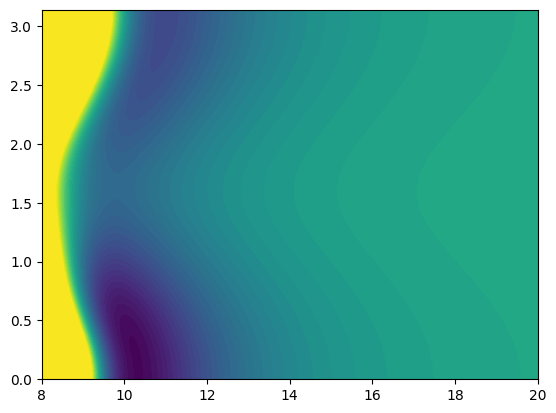

In [4]:
import matplotlib.pyplot as plt

r = np.linspace(8, 20, 300)
theta = np.linspace(0, np.pi, 100)

theta_mesh, r_mesh = np.meshgrid(theta, r, indexing="ij")
potential = Potential.default()
potential.alpha *= 5

potential_array = potential.value(r_mesh, theta_mesh) / CM_INV

potential_array = np.clip(potential_array, -1000, 100)

fig, ax = plt.subplots()
ax.contourf(r, theta, potential_array, levels=50)

# Changing potentials

In [5]:
scalings = [0.1, 0.2, 0.5, 1, 2, 5, 10]

## changing dipole

In [26]:
for scaling in scalings:
    print("dipole scaling", scaling)
    potential = Potential.default()
    potential.alpha *= scaling

    j_init = 0
    omega_init = 0
    losses = CumulativeLosses(j_init)

    for j_tot in tqdm(losses.j_totals):
        propagation = prepare(j_init, omega_init, j_tot, potential=potential)
        propagation.propagate()
        losses.extract_loss(propagation)
    losses.save_losses(f"dipole_scaling_{scaling}_{j_init}_{omega_init}")


dipole scaling 0.001


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [04:35<00:00,  5.50s/it]


dipole scaling 0.1


100%|██████████| 50/50 [04:36<00:00,  5.52s/it]


dipole scaling 0.2


100%|██████████| 50/50 [04:33<00:00,  5.48s/it]


dipole scaling 0.5


100%|██████████| 50/50 [04:32<00:00,  5.44s/it]


dipole scaling 1


100%|██████████| 50/50 [04:34<00:00,  5.49s/it]


dipole scaling 2


100%|██████████| 50/50 [04:31<00:00,  5.43s/it]


dipole scaling 5


100%|██████████| 50/50 [04:36<00:00,  5.54s/it]


dipole scaling 10


100%|██████████| 50/50 [04:30<00:00,  5.41s/it]


dipole scaling 100


 20%|██        | 10/50 [00:55<03:46,  5.67s/it]

In [6]:
for scaling in scalings:
    print("dipole scaling", scaling)
    potential = Potential.default()
    potential.alpha *= scaling

    j_init = 1
    omega_init = 0
    losses = CumulativeLosses(j_init)

    for j_tot in tqdm(losses.j_totals):
        propagation = prepare(j_init, omega_init, j_tot, potential=potential)
        propagation.propagate()
        losses.extract_loss(propagation)
    losses.save_losses(f"dipole_scaling_{scaling}_{j_init}_{omega_init}")


dipole scaling 0.1


100%|██████████| 50/50 [04:33<00:00,  5.47s/it]


dipole scaling 0.2


100%|██████████| 50/50 [04:32<00:00,  5.46s/it]


dipole scaling 0.5


100%|██████████| 50/50 [04:33<00:00,  5.46s/it]


dipole scaling 1


100%|██████████| 50/50 [04:31<00:00,  5.43s/it]


dipole scaling 2


100%|██████████| 50/50 [04:32<00:00,  5.45s/it]


dipole scaling 5


100%|██████████| 50/50 [04:31<00:00,  5.43s/it]


dipole scaling 10


100%|██████████| 50/50 [04:32<00:00,  5.45s/it]


In [7]:
for scaling in scalings:
    print("dipole scaling", scaling)
    potential = Potential.default()
    potential.alpha *= scaling

    j_init = 1
    omega_init = 1
    losses = CumulativeLosses(j_init)

    for j_tot in tqdm(losses.j_totals):
        propagation = prepare(j_init, omega_init, j_tot, potential=potential)
        propagation.propagate()
        losses.extract_loss(propagation)
    losses.save_losses(f"dipole_scaling_{scaling}_{j_init}_{omega_init}")


dipole scaling 0.1


100%|██████████| 50/50 [03:45<00:00,  4.51s/it]


dipole scaling 0.2


100%|██████████| 50/50 [03:45<00:00,  4.50s/it]


dipole scaling 0.5


100%|██████████| 50/50 [03:47<00:00,  4.54s/it]


dipole scaling 1


100%|██████████| 50/50 [03:46<00:00,  4.53s/it]


dipole scaling 2


100%|██████████| 50/50 [03:35<00:00,  4.31s/it]


dipole scaling 5


100%|██████████| 50/50 [03:35<00:00,  4.32s/it]


dipole scaling 10


100%|██████████| 50/50 [03:37<00:00,  4.35s/it]
